In [17]:
#Install dependencies
#!pip install geopandas

import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

In [18]:
#get data
zipatalalist = pd.read_csv('../data/Clinics/MHFRlandscape.csv')
coveragefile = geopandas.read_file('../out/health_clinics.dbf')
TAdata = pd.read_csv('../data/Clinics/TA Org Units Cleaned.csv')

#join landscape data with TAs
zipatalalist = zipatalalist.merge(TAdata, left_on='ta', right_on='Short name', how='left')

#define_fields
zipatalalist = zipatalalist[['facility_code', 'facility_name', 'ta', 'district', 'facility_type', 'langitude','latitude','Name' ]]
len(zipatalalist)


1588

In [11]:
#rename columns
zipatalalist.columns = ['ID_2', 'CLINIC_NAME', 'NAME_2(MHFR)', 'NAME_1', 'CLINIC_TYPE', 'langitude', 'latitude', 'NAME_2']
#Add default columns from coverage file
zipatalalist['TYPE_2'] = np.where(zipatalalist.NAME_2.str.startswith('TA'), 'Traditional Authority',
                                  np.where(zipatalalist.NAME_2.str.startswith('STA'), 'Sub Traditional Authority', ''))
zipatalalist =  zipatalalist.assign(ID_0='157', ISO='MWI', ENGTYPE_2 = zipatalalist['TYPE_2'], VALIDFR_2 ='Unknown',VALIDTO_2 = 'Unknown')
#filter facility_type as clinics only
zipatalalist_clinic = zipatalalist.drop(zipatalalist[zipatalalist.CLINIC_TYPE == "Dispensary"].index & zipatalalist[zipatalalist.CLINIC_TYPE == "Health Post"].index)
#drop all coordinates that are out of bound : langitude <31 and >36 && latitude = -23
zipatalalist_clinic = zipatalalist_clinic.drop(zipatalalist_clinic[zipatalalist_clinic.langitude < 31].index)
zipatalalist_clinic = zipatalalist_clinic.drop(zipatalalist_clinic[zipatalalist_clinic.langitude > 36].index)
zipatalalist_clinic = zipatalalist_clinic.drop(zipatalalist_clinic[zipatalalist_clinic.latitude == -23].index)
zipatalalist_clinic = zipatalalist_clinic[zipatalalist_clinic['langitude'].notna()]
len(zipatalalist_clinic)

1407

In [12]:
#transform lat and long into list
crs = {'init': 'epsg:4326'}
#gdf = geopandas.GeoDataFrame(zipatalalist_clinic, geometry=geopandas.points_from_xy(zipatalalist_clinic.langitude, zipatalalist_clinic.latitude))
gdf = [Point(xy) for xy in zip(zipatalalist_clinic['langitude'], zipatalalist_clinic['latitude'])]
zipatalalist_clinic = geopandas.GeoDataFrame(zipatalalist_clinic, crs=crs, geometry=gdf)

/Users/ibwighane/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [13]:
#Add shape length, area
zipatalalist_clinic['Shape_Leng'] = zipatalalist_clinic.geometry.length
zipatalalist_clinic['Shape_Area'] = zipatalalist_clinic.geometry.area
zipatalalist_clinic['geometry'] = zipatalalist_clinic['geometry'].buffer(0.05)
#delete lat longitude
#zipatalalist_clinic = zipatalalist_clinic.drop(['langitude','latitude'], axis=1, inplace=True)
zipatalalist_clinic = pd.DataFrame(zipatalalist_clinic).reset_index()
#Buffer to coverage file
coveragefile['geometry'] = coveragefile['geometry'].buffer(0.045)
len(zipatalalist_clinic)

<ipython-input-13-3f021b02a6fc>:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zipatalalist_clinic['Shape_Leng'] = zipatalalist_clinic.geometry.length
<ipython-input-13-3f021b02a6fc>:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zipatalalist_clinic['Shape_Area'] = zipatalalist_clinic.geometry.area
<ipython-input-13-3f021b02a6fc>:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zipatalalist_clinic['geometry'] = zipatalalist_clinic['geometry'].buffer(0.05)
<ipython-input-13-3f021b02a6fc>:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorre

1407

<AxesSubplot:>

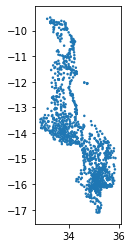

In [14]:
#Append coverage file into zipatala_clinic file
coveragefile = coveragefile.append(zipatalalist_clinic, ignore_index=True)
#coveragefile.head() #to view sample of the file
coveragefile.plot()

In [16]:
coveragefile.to_file('../out/new/zipatala.shp', driver='ESRI Shapefile', index = False)
len(coveragefile)

<ipython-input-16-6ebed42287e9>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  coveragefile.to_file('../out/new/zipatala.shp', driver='ESRI Shapefile', index = False)


1507